### Imports

In [1]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from typing_extensions import Literal
from langchain.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
import json
from typing import List, Dict
import operator

### Initialize the LLM

In [2]:
load_dotenv()

groq_key = os.getenv("groq_api_key")
os.environ["GROQ_API_KEY"] = groq_key

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0
)

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(None, description="The next step in the routing process")
    topic: str = Field(None, description="The topic for the content generation")

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

# State

In [3]:
class State(TypedDict):
    input: str
    decision: str
    topic: str
    output: str

### Nodes & Router functions

In [5]:
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(f"Write a story about {state['topic']}")
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(f"Write a joke about {state['topic']}")
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(f"Write a poem about {state['topic']}")
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="""Return 
                1. step of either 'poem', 'story', or 'joke' based on the user's input. The step should indicate the type of content to generate.
                2. topic which is the subject matter for the content generation.
                """
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step, "topic": decision.topic}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "story"
    elif state["decision"] == "joke":
        return "joke"
    elif state["decision"] == "poem":
        return "poem"


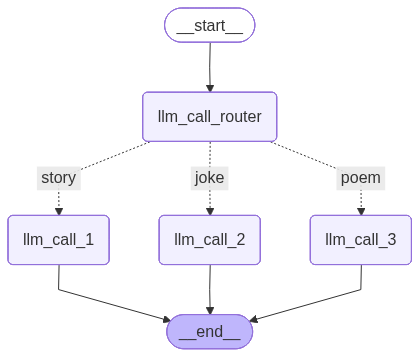

In [6]:
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "story": "llm_call_1",
        "joke": "llm_call_2",
        "poem": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Save the workflow as image
# router_workflow.get_graph().draw_mermaid_png(output_file_path="router_flow.png")

### Invoke

In [7]:
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(json.dumps(state, indent=4))

{
    "input": "Write me a joke about cats",
    "decision": "joke",
    "topic": "cats",
    "output": "Why did the cat join a band?\n\nBecause it wanted to be the purr-cussionist!"
}


In [8]:
for node in router_workflow.stream({"input": "Write me a joke about cats"}):
    print(node)

{'llm_call_router': {'decision': 'joke', 'topic': 'cats'}}
{'llm_call_2': {'output': 'Why did the cat join a band?\n\nBecause it wanted to be the purr-cussionist!'}}


### Handle multiple topics in the same flow

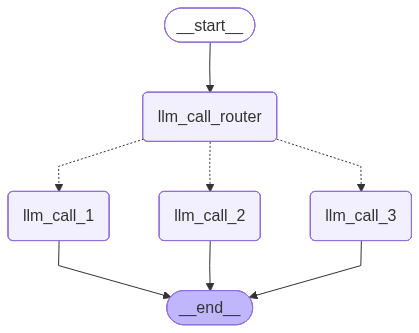

In [9]:
# 1️⃣ Change the router schema (single → multiple topics)
#    Instead of a single Literal, return a list of Literals.    

class Route(BaseModel):
    # step: Literal["poem", "story", "joke"] = Field(None, description="The next step in the routing process")
    steps: List[Literal["poem", "story", "joke"]] = Field(description="One or more content types requested by the user")
    topic: str = Field(None, description="The topic for the content generation")

router = llm.with_structured_output(Route)

# 2️⃣ Modify state to support aggregation
#    change type of decision to List[str] and outputs to dict to store outputs from each node

class State(TypedDict):
    input: str
    # decision: str
    decisions: List[str]
    topic: str
    # output: str
    outputs: Annotated[Dict[str, str], operator.or_]

# 3️⃣ Update content nodes to append instead of replace

def llm_call_1(state: State):
    result = llm.invoke(f"Write a story about {state['topic']}")
    # return {"output": result.content}
    return {"outputs": {"story": result.content}}

def llm_call_2(state: State):
    result = llm.invoke(f"Write a joke about {state['topic']}")
    # return {"output": result.content}
    return {"outputs": {"joke": result.content}}

def llm_call_3(state: State):
    result = llm.invoke(f"Write a poem about {state['topic']}")
    # return {"output": result.content}
    return {"outputs": {"poem": result.content}}

# 4️⃣ Router node now returns multiple decisions

# def llm_call_router(state: State):
#     """Route the input to the appropriate node"""
#     # Run the augmented LLM with structured output to serve as routing logic
#     decision = router.invoke(
#         [
#             SystemMessage(
#                 content="""Return 
#                 1. step of either 'poem', 'story', or 'joke' based on the user's input. The step should indicate the type of content to generate.
#                 2. topic which is the subject matter for the content generation.
#                 """
#             ),
#             HumanMessage(content=state["input"]),
#         ]
#     )
#     return {"decision": decision.step, "topic": decision.topic}

def llm_call_router(state: State):
    decision = router.invoke(
        [
            SystemMessage(
                content="Identify ALL steps requested: poem, story, joke. And a topic for the content generation based on the user's input."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {
        "decisions": decision.steps,
        "topic": decision.topic,
        "outputs": {}  # initialize aggregation
    }

# 5️⃣ Fan-out routing

# def route_decision(state: State):
#     # Return the node name you want to visit next
#     if state["decision"] == "story":
#         return "llm_call_1"
#     elif state["decision"] == "joke":
#         return "llm_call_2"
#     elif state["decision"] == "poem":
#         return "llm_call_3"

def route_decision(state: State):
    mapping = {
        "story": "llm_call_1",
        "joke": "llm_call_2",
        "poem": "llm_call_3",
    }

    return [mapping[d] for d in state["decisions"]]

# NO CHANGE

router_builder = StateGraph(State)

router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

router_builder.add_edge(START, "llm_call_router")

router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)

router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [10]:
for node in router_workflow.stream({"input": "Write a joke and a poem about cats"}):
    print(node)

{'llm_call_router': {'decisions': ['joke', 'poem'], 'topic': 'cats', 'outputs': {}}}
{'llm_call_2': {'outputs': {'joke': 'Why did the cat join a band?\n\nBecause it wanted to be the purr-cussionist!'}}}
{'llm_call_3': {'outputs': {'poem': "Whiskers twitch, ears perk up high,\nAs feline forms go gliding by,\nTheir fur a soft and silky treat,\nInviting touch, a gentle greet.\n\nWith eyes like jewels, bright and green,\nThey prowl through night, or lounge serene,\nTheir purrs a soothing, rumbling sound,\nAs they curl up, snug, in a cozy round.\n\nTheir claws, sharp-tipped, extend and retract,\nAs they climb high, or pounce on a fact,\nTheir agility, a wondrous sight,\nAs they leap and bound, with effortless might.\n\nTheir independence, a curious thing,\nAs they come and go, with a flick of their wing,\nTheir affection, a precious, rare delight,\nGiven freely, but only in their sight.\n\nOh, cats, oh cats, with your mysterious ways,\nYou rule our hearts, and brighten up our days,\nWith yo

In [11]:
ouput = router_workflow.invoke({"input": "Write a joke and a poem about cats"})
print(json.dumps(ouput, indent=4))

{
    "input": "Write a joke and a poem about cats",
    "decisions": [
        "joke",
        "poem"
    ],
    "topic": "cats",
    "outputs": {
        "joke": "Why did the cat join a band?\n\nBecause it wanted to be the purr-cussionist!",
        "poem": "Whiskers twitch, ears perk up high,\nAs feline forms go gliding by,\nTheir fur a soft and silky treat,\nInviting touch, a gentle greet.\n\nWith eyes like jewels, bright and wide,\nThey watch the world, with secret pride,\nTheir little noses sniff the air,\nAs they prowl, without a single care.\n\nTheir purrs a soothing, rumbling sound,\nAs they curl up, in a cozy mound,\nTheir tails a-twitch, a language all their own,\nAs they communicate, in a feline tone.\n\nWith claws that shine, like tiny knives,\nThey climb the curtains, with agile strives,\nAnd when they sleep, they sleep so deep,\nTheir dreams of mice, and feathers keep.\n\nOh, cats, oh cats, with your mysterious ways,\nYou rule the house, with your gentle sway,\nYou bring